In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
df = pd.read_csv("used_cars.csv")

In [2]:
# Check total number of missing values
total_missing = df.isnull().sum()
print(f"Total missing values in the dataset: ")
print(f"{total_missing}")

Total missing values in the dataset: 
brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64


As displayed above we have 170 rows with missing fuel type. In our unprocessed dataset electricity isn't used as a fuel type. To fix this we set all of the rows where the "engine" column contains the word "electric" to fuel type electric. Same is done for all the rows where brand contains "tesla", which we all know is a manufacturer of electric vehicles. This leaves us with 2 rows that have missing fuel_type values. Based on our manual observation those rows represent KIA EV6 and Ford Mustang Mach-E which both are also electric.

Since in the dataset there are 45 rows with fuel_type "–" (missing) we decided to replace them with the most common value for the row.

In [4]:
#Engine contains "electric" --> fuel_type = "electric"
df.loc[df['engine'].str.contains('electric', case=False, na=False), 'fuel_type'] = 'Electric' #this leaves us with 5 NaN fuels
#Brand contains "tesla" --> fuel_type = "electric"
df.loc[df['brand'].str.contains('tesla', case=False, na=False), 'fuel_type'] = 'Electric' #this leaves us with 2 NaN fuels
#Rest of the missing values are set to "electric".
df['fuel_type'].fillna('Electric', inplace=True) #this changes the remaining NaN values

# Find the most common value in the 'fuel_type' column (excluding '-')
most_common_fuel_type = df['fuel_type'].mode()[0]
# Replace all '–' in the 'fuel_type' column with the most common value
df['fuel_type'].replace('–', most_common_fuel_type, inplace=True)

# Show all unique values left in the 'fuel_type' column
fuel_types = df['fuel_type'].unique()
print(fuel_types)
df.isnull().sum()

['E85 Flex Fuel' 'Gasoline' 'Electric' 'Hybrid' 'Diesel']


brand             0
model             0
model_year        0
milage            0
fuel_type         0
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

Handling missing accident values (113): we've decided to replace them with the most common value for the accident column. (That being "None reported")

In [6]:
most_common_accident = df['accident'].mode()[0]
df['accident'].fillna(most_common_accident, inplace=True)
# Check if there are still missing values
print(df.isnull().sum())

brand             0
model             0
model_year        0
milage            0
fuel_type         0
engine            0
transmission      0
ext_col           0
int_col           0
accident          0
clean_title     596
price             0
dtype: int64


Handling missing clean_title values: Since all of the values present in the column are "yes" we decided to replace all of the missing values with "no".

In [8]:
#changing null values in clean_title to no, since all of the non-nulls are "yes"
df['clean_title'].fillna('No', inplace=True)
print(df.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64


Engine column: Because this column in just a full of engine attributes we've decided to extract the 2 most important: displacement and power.

In [10]:
# Creating empty columns for power and displacement.
df['power'] = None
df['displacement'] = None
pattern_power = r'(\d+(\.\d+)?)\s*HP' # Define the pattern to match horsepower values like '150 HP' or '150hp'
pattern_displacement = r'(\d+(\.\d+)?)\s*(L|Liter)\b' # Define the pattern to match displacement values like '2.4L' or '2.4 Liter'
#Extracting power values
df.loc[df['engine'].str.contains('HP', case=False, na=False), 'power'] = \
    df['engine'].str.extract(pattern_power, expand=False)[0].astype(float)
#Extracting displacement values
df.loc[df['engine'].notna(), 'displacement'] = \
    df['engine'].str.extract(pattern_displacement, expand=False)[0].astype(float)

df.drop(columns=['engine'], inplace=True)

In [11]:
print(df.isnull().sum())

brand             0
model             0
model_year        0
milage            0
fuel_type         0
transmission      0
ext_col           0
int_col           0
accident          0
clean_title       0
price             0
power           808
displacement    217
dtype: int64


Now we have to deal with the missing displacement and power values.

Electric cars don't have displacement so we'll set the displacement to -1 where the fuel_type is "electric"

After that we just fill the rest of the missing displacement values with the median (ignoring electric vehicles)

In [13]:
# Set displacement to -1 for electric vehicles where displacement is null
df.loc[df['fuel_type'] == 'electric', 'displacement'] = -1
# Calculate the median displacement value (ignoring electric vehicles)
median_displacement = df[df['fuel_type'] != 'electric']['displacement'].median()
print(f"Median displacement (excluding electric vehicles): {median_displacement}")
# Fill the null displacement values with the calculated median
df['displacement'].fillna(median_displacement, inplace=True)

# Calculate the mean of the 'Horsepower' column, ignoring NaN values
mean_horsepower = df['power'].mean()
df['power'].fillna(mean_horsepower, inplace=True)
# Print the result
print(f"Mean Horsepower: {mean_horsepower}")

Median displacement (excluding electric vehicles): 3.5
Mean Horsepower: 332.20649796938454


Changing the price column into float (removing "," and "$") <br>
Changing the milage column from miles to km (int)
Converting the model year column into age column (2024 - model year = age)

In [15]:
# Remove '$' and commas from 'price' and convert to float
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Remove 'mi' and any non-numeric characters, convert to float, then to kilometers and integer
df['milage'] = df['milage'].replace({'mi': '', '[^\d.]': ''}, regex=True).astype(float) * 1.60934
# Convert the milage to an integer (rounded down)
df['milage'] = df['milage'].astype(int)

# Convert model year into age based on 2024
df['age'] = 2024 - df['model_year']

#Getting rid of the model year column
df.drop(columns=['model_year'], inplace=True)

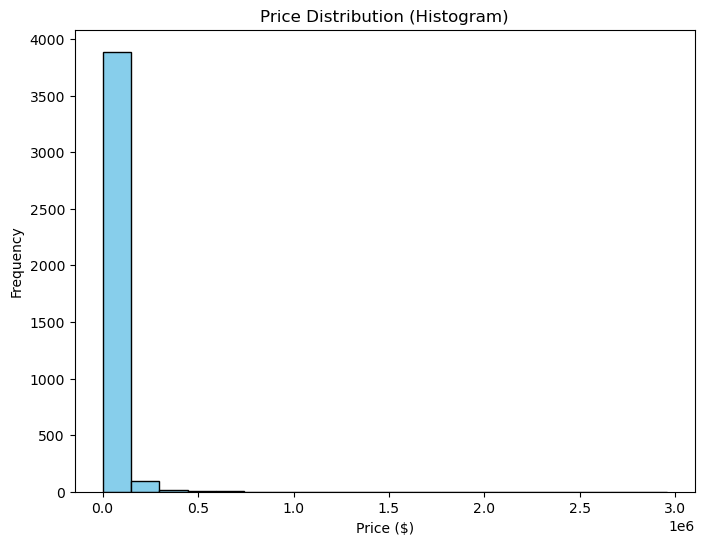

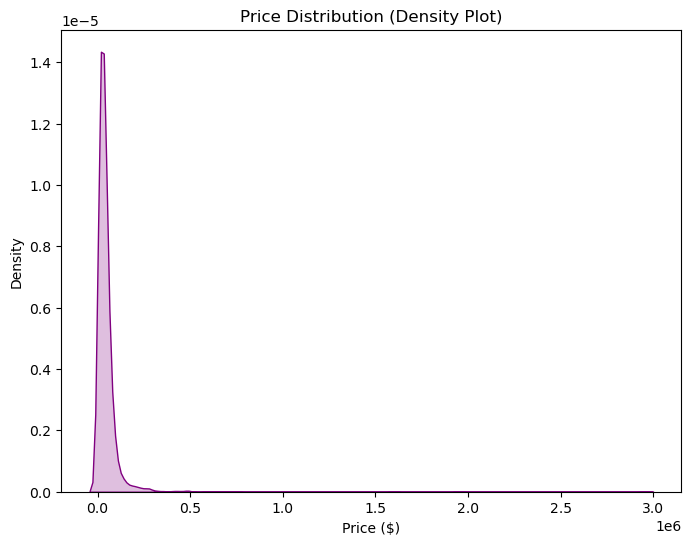

count    4.009000e+03
mean     4.455319e+04
std      7.871064e+04
min      2.000000e+03
25%      1.720000e+04
50%      3.100000e+04
75%      4.999000e+04
max      2.954083e+06
Name: price, dtype: float64

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(df['price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Price Distribution (Histogram)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(df['price'], color='purple', shade=True)
plt.title('Price Distribution (Density Plot)')
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.show()

df['price'].describe()

The above descriptive analysis shows that the price column has a wider standard deviation and shows that it has potential outliers that should be removed

In [18]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['price'] < (Q1 - 1.5 * IQR)) |(df['price'] > (Q3 + 0.5 * IQR)))] #Changed the multiplier so that the graph below looked right to us :)

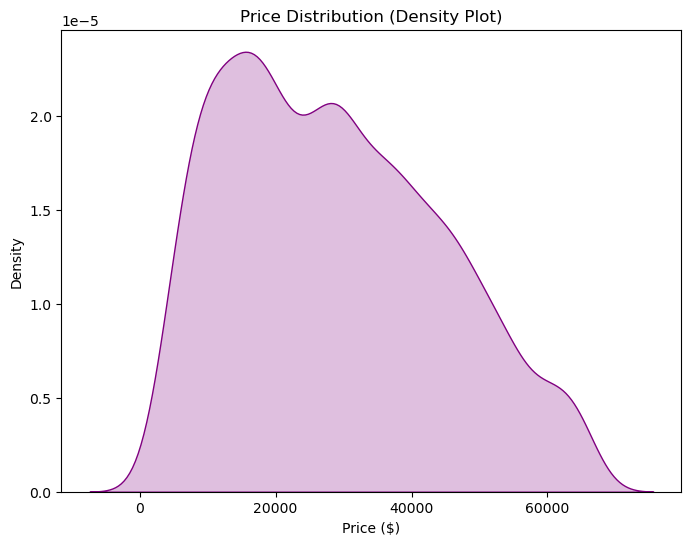

In [19]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df['price'], color='purple', shade=True)
plt.title('Price Distribution (Density Plot)')
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.show()

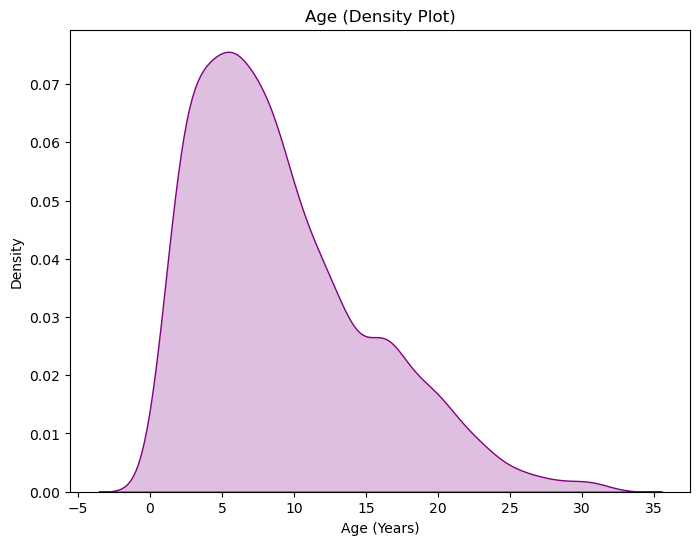

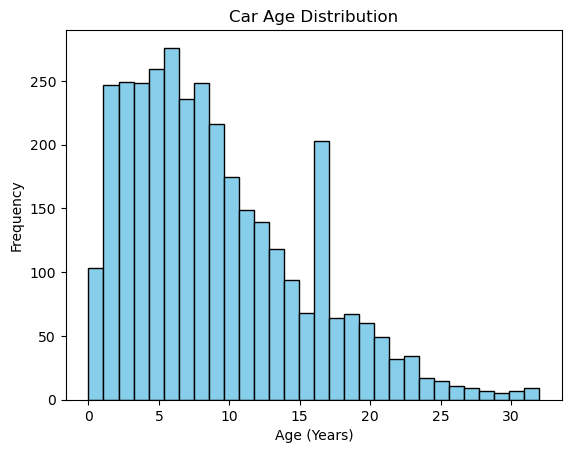

count    3414.000000
mean        9.202109
std         6.068042
min         0.000000
25%         5.000000
50%         8.000000
75%        13.000000
max        32.000000
Name: age, dtype: float64

In [20]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df['age'], color='purple', shade=True)
plt.title('Age (Density Plot)')
plt.xlabel('Age (Years)')
plt.ylabel('Density')
plt.show()

plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Car Age Distribution')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.show()

df['age'].describe()

Decided to limit the age to 20 years, since we feel like above that there are more and more outliers.

In [22]:
df = df[df['age'] <= 20]

This is the final form of our data

In [24]:
df.head()

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,power,displacement,age
0,Ford,Utility Police Interceptor Base,82076,E85 Flex Fuel,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0,300.000000,3.7,11
1,Hyundai,Palisade SEL,55911,Gasoline,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0,332.206498,3.8,3
2,Lexus,RX 350 RX 350,36004,Gasoline,Automatic,Blue,Black,None reported,No,54598.0,332.206498,3.5,2
3,INFINITI,Q50 Hybrid Sport,143070,Electric,7-Speed A/T,Black,Black,None reported,Yes,15500.0,354.000000,3.5,9
4,Audi,Q3 45 S line Premium Plus,15827,Gasoline,8-Speed Automatic,Glacier White Metallic,Black,None reported,No,34999.0,332.206498,2.0,3


Encoding the non-numeric columns so that the models can use them :)

In [26]:
label_encoder = LabelEncoder()

df['brand'] = label_encoder.fit_transform(df['brand'])
encoded_values = label_encoder.transform(label_encoder.classes_)
brand_mapping = dict(zip(encoded_values, label_encoder.classes_)) #for graphing
df['fuel_type'] = label_encoder.fit_transform(df['fuel_type'])
df['transmission'] = label_encoder.fit_transform(df['transmission'])
df['accident'] = label_encoder.fit_transform(df['accident'])
df['clean_title'] = label_encoder.fit_transform(df['clean_title'])
df['ext_col'] = label_encoder.fit_transform(df['ext_col'])
df['int_col'] = label_encoder.fit_transform(df['int_col'])

# Model training?

In [28]:
X = df.drop(columns=['price', 'model'])  
y = df['price']  # Target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model
rf_model = RandomForestRegressor(random_state=42)
param_grid = { #only the best remaining (removed others while testing, but I'll keep the block)
    'n_estimators': [200], 
    'max_depth': [None],  
    'min_samples_split': [5], 
    'min_samples_leaf': [1],  
    'max_features': ['sqrt', 0.5],  
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
rf_model = grid_search.best_estimator_
rf_model.fit(X_train, y_train)

#Evaluation metrics
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest Results:")
print(f"Mean Absolute Error: {rf_mae}")
print(f"Root Mean Squared Error: {rf_rmse}")
print(f"R^2 Score: {rf_r2}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Results:
Mean Absolute Error: 4771.442263007265
Root Mean Squared Error: 6575.5178096189275
R^2 Score: 0.8091290160278422


Random Forest MAE as percentage: 16.22%
Random Forest Prediction Comparison:
      Actual Value  Predicted Value    Difference
382         9750.0     10820.800702  -1070.800702
132        30000.0     43205.570889 -13205.570889
2305       15400.0     14143.709853   1256.290147
1496       46998.0     48285.750735  -1287.750735
3710       21500.0     35085.970913 -13585.970913


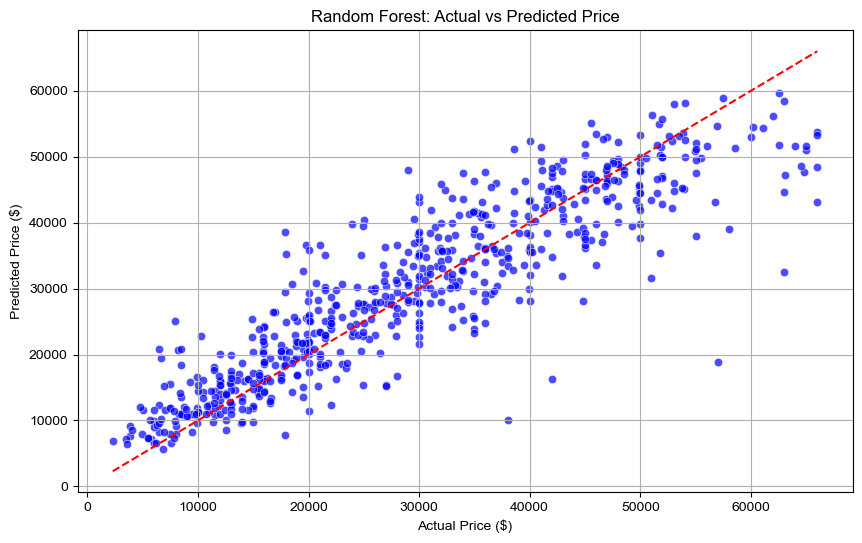

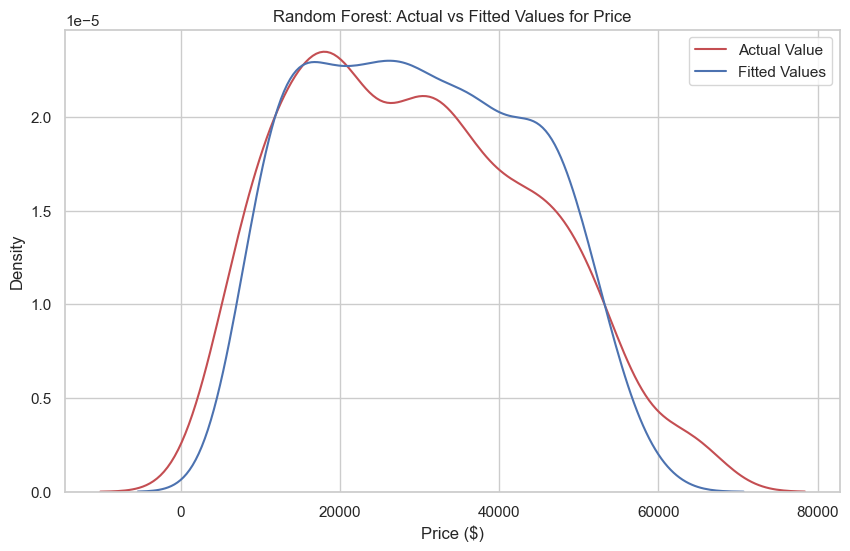

In [29]:
#Dataframe for comparing
rf_pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': rf_predictions,
    'Difference': y_test - rf_predictions
})
# Calculate MAE as a percentage
rf_mae_percent = (rf_mae / y_test.mean()) * 100
print(f"Random Forest MAE as percentage: {rf_mae_percent:.2f}%")
print("Random Forest Prediction Comparison:")
print(rf_pred_df.head())  #First rows of comparison

#Plot scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rf_pred_df['Actual Value'], y=rf_pred_df['Predicted Value'], color='blue', alpha=0.7)
plt.plot([rf_pred_df['Actual Value'].min(), rf_pred_df['Actual Value'].max()],
         [rf_pred_df['Actual Value'].min(), rf_pred_df['Actual Value'].max()],
         color='red', linestyle='--')
plt.title('Random Forest: Actual vs Predicted Price')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True)

#Density plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(rf_pred_df['Actual Value'], color="r", label="Actual Value")
sns.kdeplot(rf_pred_df['Predicted Value'], color="b", label="Fitted Values")
plt.title('Random Forest: Actual vs Fitted Values for Price')
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 5115.13
Mean Absolute Error (MAE) as percentage: 17.25%
R-squared: 0.8075


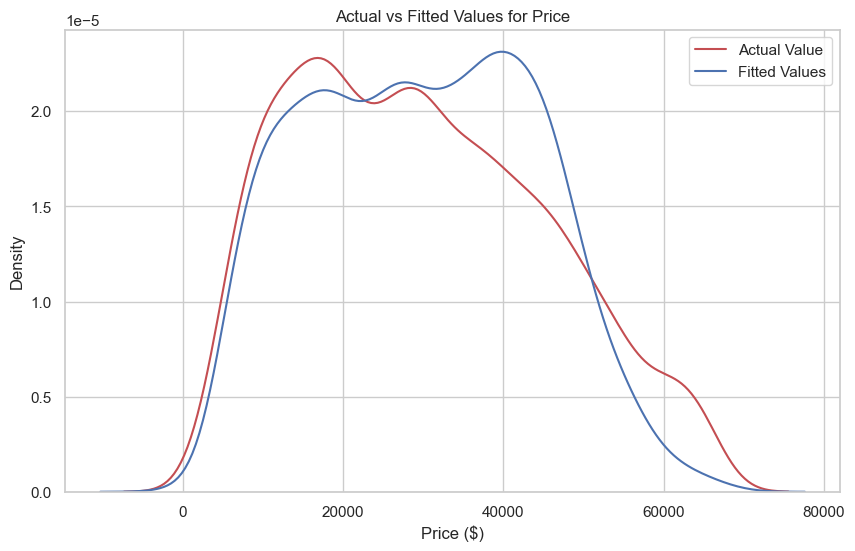

In [30]:
#Polynomial Regression 
Z = df[['brand', 'fuel_type', 'transmission', 'age', 'milage', 'power', 'displacement', 'ext_col', 'int_col', 'accident', 'clean_title']] #input features
y = y[Z.index]  

input_pipeline = [
    ('scale', StandardScaler()),  #scaling
    ('polynomial', PolynomialFeatures(include_bias=False, degree=3)),  #3.degree, poly features
    ('model', LinearRegression())  # LR model
]

pipe = Pipeline(input_pipeline)
pipe.fit(Z, y)
ypipe = pipe.predict(Z)

#Evaluation
mae = mean_absolute_error(y, ypipe)
mae_percentage = (mae / y.mean()) * 100
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Error (MAE) as percentage: {mae_percentage:.2f}%")
r2 = pipe.score(Z, y)
print(f"R-squared: {r2:.4f}")

# Plot Actual vs Fitted Values for Price (Density Plot)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(y, color="r", label="Actual Value")
sns.kdeplot(ypipe, color="b", label="Fitted Values")
plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

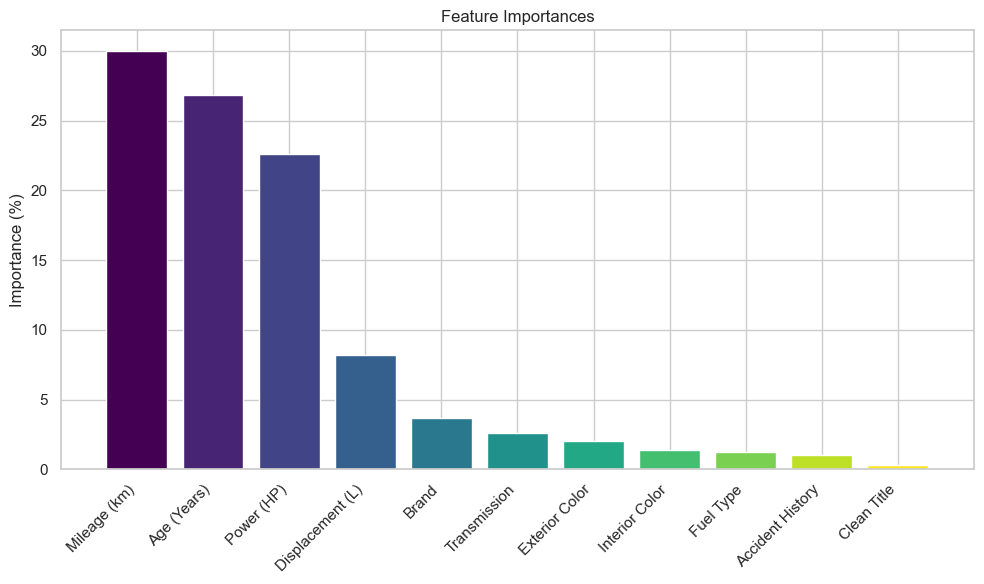

In [31]:
# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X.columns
feature_name_map = { #improved readability
    'fuel_type': 'Fuel Type',
    'transmission': 'Transmission',
    'milage': 'Mileage (km)',
    'age': 'Age (Years)',
    'brand': 'Brand',
    'power': 'Power (HP)',
    'displacement': 'Displacement (L)',
    'accident': 'Accident History',
    'clean_title': 'Clean Title',
    'ext_col': 'Exterior Color',
    'int_col': 'Interior Color'
}
feature_names = [feature_name_map.get(name, name) for name in feature_names] #mapping new names
indices = np.argsort(importances)[::-1] #sorting

# Plotting
cmap = plt.cm.get_cmap("viridis", len(importances))  
colors = cmap(np.linspace(0, 1, len(importances)))
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
bars = plt.bar(range(X.shape[1]), importances[indices] * 100, color=colors, align="center")  # Multiply by 100 to convert to percentage
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.ylabel("Importance (%)")  # Y-telje nimetus
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

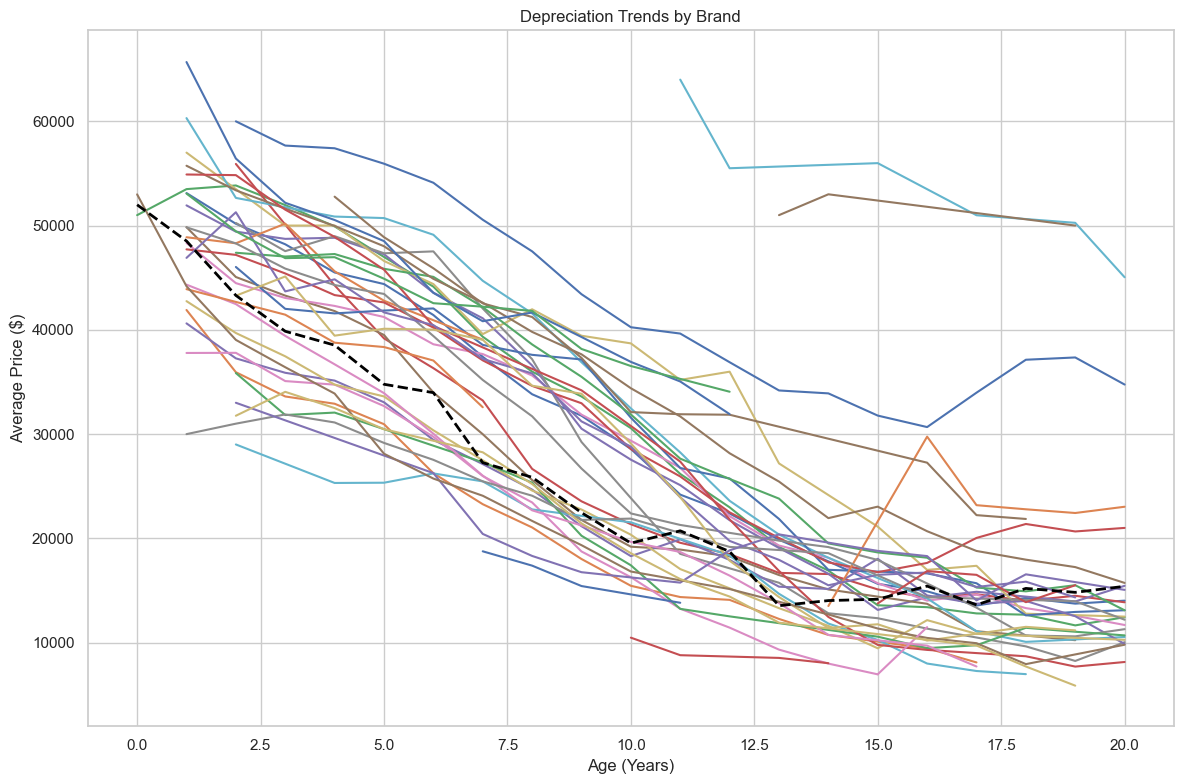

In [32]:
brand_depreciation = df.groupby(["brand", "age"])["price"].mean().reset_index() # data  grouped by brand and age, then calculating average price
average_depreciation = brand_depreciation.groupby("age")["price"].mean().reset_index() #average price across all brands for each age
window_size = 5

# Plotting
plt.figure(figsize=(12, 8))
for brand in df["brand"].unique():
    brand_data = brand_depreciation[brand_depreciation["brand"] == brand]
    brand_data["smoothed_price"] = brand_data["price"].rolling(window=window_size, min_periods=1).mean()
    plt.plot(brand_data["age"], brand_data["smoothed_price"])
plt.plot(average_depreciation["age"], average_depreciation["price"], label="Average", color="black", linestyle="--", linewidth=2)
plt.title("Depreciation Trends by Brand")
plt.xlabel("Age (Years)")
plt.ylabel("Average Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

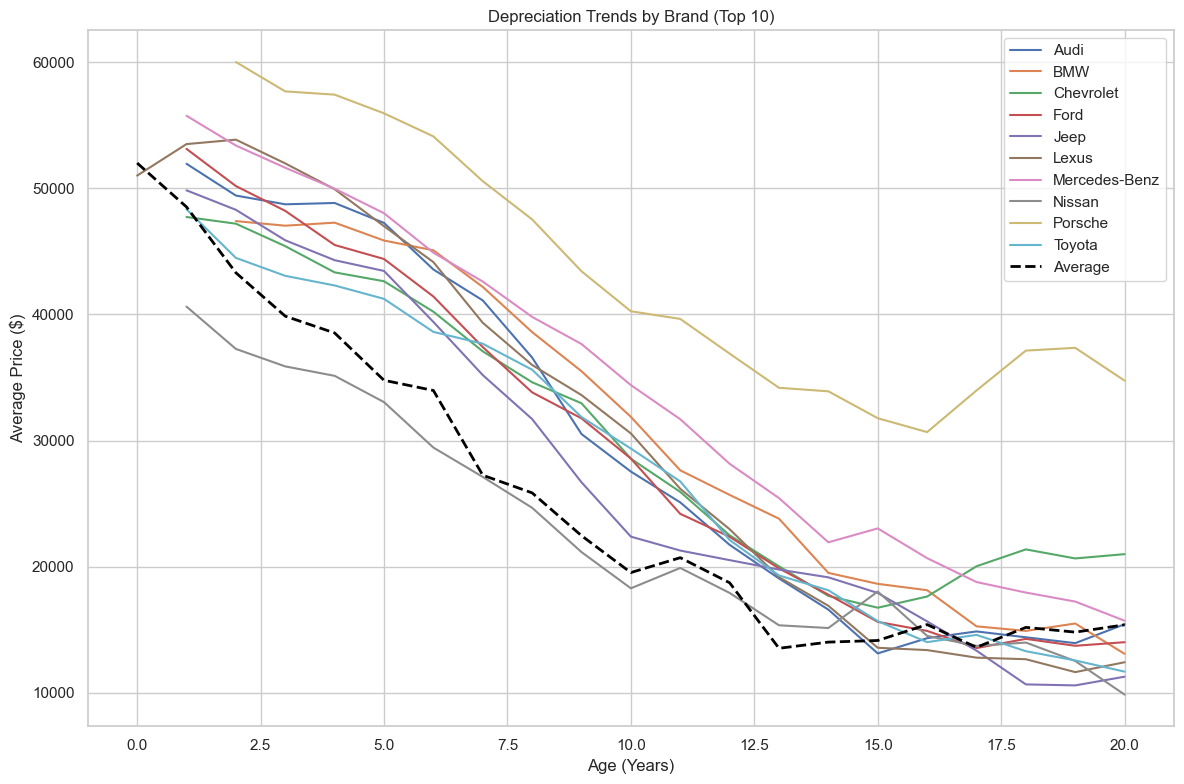

In [33]:
#top 10 most common brands
top_10_brands = df["brand"].value_counts().head(10).index 
brand_depreciation_top10 = brand_depreciation[
    brand_depreciation["brand"].isin(top_10_brands)
]

# Plotting
plt.figure(figsize=(12, 8))
for brand in brand_depreciation_top10["brand"].unique():
    brand_data = brand_depreciation_top10[
        brand_depreciation_top10["brand"] == brand
    ]
    brand_data["smoothed_price"] = brand_data["price"].rolling(window=5, min_periods=1).mean()
    brand_name = brand_mapping.get(brand)  # Assuming brand_mapping exists to map brand IDs to names
    plt.plot(brand_data["age"], brand_data["smoothed_price"], label=brand_name)
plt.plot(average_depreciation["age"], average_depreciation["price"], label="Average", color="black", linestyle="--", linewidth=2)
plt.title("Depreciation Trends by Brand (Top 10)")
plt.xlabel("Age (Years)")
plt.ylabel("Average Price ($)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()